# <center>Applied Data Science Capstone - Peer-graded Assignment 2</center>
# <center>Segmenting and Clustering Neighborhoods in Toronto </center>

### 1. Get postal codes from Wikipedia

In [4]:
import requests

# Get html content:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html = requests.get(url).content

In [5]:
from scrapy import Selector

# Parse html and find tags containing requested info:
sel = Selector(text=html)
rows = sel.css('table.wikitable > tbody > tr')

In [6]:
# Create list to store parsed rows:
table_rows = []

# Iterate over rows and extract information:
for row in rows[1:]:  # Ommit the first row, it is the table header
    text = row.css('td ::text').extract()  # returns list of strings, could be more than 3 items
    postcode = text[0]
    borough  = text[1]
    neighbor = text[2].replace('\n','')
    
    # If Neighborhood isn't assigned, replace it with Borough name:
    neighbor = borough if neighbor == 'Not assigned' else neighbor
    
    # Append only codes where Borough is assigned:
    if borough != 'Not assigned':
        table_rows.append(
            {'Postcode'     : postcode,
             'Borough'      : borough,
             'Neighborhood': neighbor
            }
        )

In [7]:
import pandas as pd

# Convert the list into the pandas DataFrame:
df = pd.DataFrame(table_rows, columns=['Postcode','Borough','Neighborhood'])
df.head()

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


In [8]:
# Group neighborhoods by Postcodes:
df = df.groupby(['Postcode','Borough'])['Neighborhood'].apply(lambda x: ', '.join(x)).to_frame().reset_index()
print('The dataframe shape:', df.shape)
df.head()

The dataframe shape: (103, 3)


,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


---

### 2. Get coordinades

In [6]:
# !pip3 install geocoder

In [7]:
import geocoder

# for pcode in result.Postcode.unique():
#     answer = None
#     while(answer is None):
#         answer = geocoder.google('{}, Toronto, Ontario'.format(pcode)).latlng
#     print('Successfully retrieved coordinates for {}'.format(pcode))
#     result.loc[result.Postcode == pcode, 'Latitude'] = answer[0]
#     result.loc[result.Postcode == pcode, 'Longitude'] = answer[1]

Geocoder didn't return any results, let's try another way: 

In [8]:
# !pip3 install geopy

In [9]:
from geopy.geocoders import Nominatim

# Make a copy of the dataframe:
result_c = df.copy()

geolocator = Nominatim(user_agent="foursquare_agent")

for pcode in result_c.Postcode.unique():
    location = geolocator.geocode('{}, Toronto, Ontario'.format(pcode))
    try:
        result_c.loc[result.Postcode == pcode, 'Latitude']  = location.latitude
        result_c.loc[result.Postcode == pcode, 'Longitude'] = location.longitude
        print('Successfully retrieved coordinates for {}'.format(pcode))
    except:
        print('Didn\'t find coordinates for {}'.format(pcode))

Didn't find coordinates for M1B
Didn't find coordinates for M1C
Didn't find coordinates for M1E
Didn't find coordinates for M1G
Didn't find coordinates for M1H
Didn't find coordinates for M1J
Didn't find coordinates for M1K
Didn't find coordinates for M1L
Didn't find coordinates for M1M
Didn't find coordinates for M1N
Didn't find coordinates for M1P
Didn't find coordinates for M1R
Didn't find coordinates for M1S
Didn't find coordinates for M1T
Didn't find coordinates for M1V
Didn't find coordinates for M1W
Didn't find coordinates for M1X
Didn't find coordinates for M2H
Didn't find coordinates for M2J
Didn't find coordinates for M2K
Didn't find coordinates for M2L
Didn't find coordinates for M2M
Didn't find coordinates for M2N
Didn't find coordinates for M2P
Didn't find coordinates for M2R
Didn't find coordinates for M3A
Didn't find coordinates for M3B
Didn't find coordinates for M3C
Didn't find coordinates for M3H
Didn't find coordinates for M3J
Didn't find coordinates for M3K
Didn't f

Not so well. We'll have to use provided csv file to extract coordinates

In [9]:
coord = pd.read_csv('Geospatial_Coordinates.csv')
coord.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [10]:
result = pd.merge(left=df,
                  right=coord,
                  left_on='Postcode',
                  right_on='Postal Code',
                  how='left').drop(columns='Postal Code')

print('Dataframe shape: ',str(result.shape))
result.head(10)

Dataframe shape:  (103, 5)


,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


In [14]:
import numpy as np
import folium
from folium.plugins import ScrollZoomToggler, MeasureControl

c_lat = np.mean([result.Latitude.max(), result.Latitude.min()])
c_lon = np.mean([result.Longitude.max(), result.Longitude.min()])

toronto_map = folium.Map(location=[c_lat, c_lon], zoom_start=11)
toronto_map.add_child(ScrollZoomToggler())
toronto_map.add_child(MeasureControl())

for pcode, borough, neigh, lat, lon in zip(*[result[c] for c in result.columns]):
    label = '{pcode}, {borough}, {neigh}'.format(pcode=pcode, borough=borough, neigh=neigh)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(location=[lat, lon],
                        popup=label,
                        color='darkblue',
                        radius=7,
                        weight=1,
                        fill=True,
                        fill_color='blue',
                        fill_opacity=0.3,
                        parse_html=False).add_to(toronto_map)

toronto_map

---

### 3. Get nearby venues

In [109]:
import json
import requests


# Create dict to store venues info:
foursquare_data = {}

# Set credentials:
CLIENT_ID = 'IBTKUPYZLKIZKZZCQP0FKFVVQ2JVFO30ZWJ0TD5LJHKWT5IN' # your Foursquare ID
CLIENT_SECRET = 'H251ZYFKWLVT0C0QTMAOUTEFU2NCMXEV4S322HM1XTP2DSNI' # your Foursquare Secret
VERSION = '20190605' # Foursquare API version

# Iterate over Postal codes and get venues info from Foursquare:
for pcode in sorted(result.Postcode.unique()):
    print('Getting info for ', str(pcode))
    lat = float(result.loc[result.Postcode == pcode, 'Latitude'])
    lon = float(result.loc[result.Postcode == pcode, 'Longitude'])

    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    lat,
    lon,
    500,
    100)
    
    # Get venues and save it into the dict:
    foursquare_data[pcode] = requests.get(url).json()

Getting info for  M1B
Getting info for  M1C
Getting info for  M1E
Getting info for  M1G
Getting info for  M1H
Getting info for  M1J
Getting info for  M1K
Getting info for  M1L
Getting info for  M1M
Getting info for  M1N
Getting info for  M1P
Getting info for  M1R
Getting info for  M1S
Getting info for  M1T
Getting info for  M1V
Getting info for  M1W
Getting info for  M1X
Getting info for  M2H
Getting info for  M2J
Getting info for  M2K
Getting info for  M2L
Getting info for  M2M
Getting info for  M2N
Getting info for  M2P
Getting info for  M2R
Getting info for  M3A
Getting info for  M3B
Getting info for  M3C
Getting info for  M3H
Getting info for  M3J
Getting info for  M3K
Getting info for  M3L
Getting info for  M3M
Getting info for  M3N
Getting info for  M4A
Getting info for  M4B
Getting info for  M4C
Getting info for  M4E
Getting info for  M4G
Getting info for  M4H
Getting info for  M4J
Getting info for  M4K
Getting info for  M4L
Getting info for  M4M
Getting info for  M4N
Getting in

In case we need the results in the future we will save the result into the pickle file:

In [15]:
# import libraries:
import pickle

# If you want to load the data from the pickle file, change 'save' to 0 or False:
save = False

if save:
    with open('foursquare_data.pkl','wb') as file:
        pickle.dump(foursquare_data, file)
        print('File saved successfully!')
else:
    with open('foursquare_data.pkl','rb') as file:
        foursquare_data = pickle.load(file)
        print('File loaded successfully!')

File loaded successfully!


Iterate over key-values pairs in the result dict and extract valuable info:

In [16]:
# Create empty data frame to store results:
venues_df = pd.DataFrame(columns=['Postcode','Venue','Venue Category','Venue Latitude','Venue Longitude'])

# Iterate over postal codes and store venue info for each in the data frame:
for pcode, data in foursquare_data.items():
    # Pass if there is no venues for this Postal code:
    if data['response']['totalResults'] == 0:
        print('There is no venues for', pcode)
    else:
        venues = data['response']['groups'][0]['items']
    
    # Convert results into pandas data frame:
    temp_df = pd.DataFrame([{'Postcode':        pcode,
                             'Venue':           v['venue']['name'],
                             'Venue Latitude':  v['venue']['location']['lat'],
                             'Venue Longitude': v['venue']['location']['lng'],
                             'Venue Category':  v['venue']['categories'][0]['name']} for v in venues])
    
    # Append results to venues_df:
    venues_df = venues_df.append(temp_df, sort=False, ignore_index=True)

There is no venues for M1X
There is no venues for M2M
There is no venues for M9A


Check the result:

In [18]:
print(venues_df.shape)
venues_df.head(10)

(2284, 5)


,Postcode,Venue,Venue Category,Venue Latitude,Venue Longitude
0,M1B,Wendy's,Fast Food Restaurant,43.807448,-79.199056
1,M1B,Interprovincial Group,Print Shop,43.805630,-79.200378
2,M1C,Chris Effects Painting,Construction & Landscaping,43.784343,-79.163742
3,M1C,Royal Canadian Legion,Bar,43.782533,-79.163085
4,M1E,Swiss Chalet Rotisserie & Grill,Pizza Place,43.767697,-79.189914
5,M1E,G & G Electronics,Electronics Store,43.765309,-79.191537
6,M1E,Marina Spa,Spa,43.766000,-79.191000
7,M1E,Big Bite Burrito,Mexican Restaurant,43.766299,-79.190720
8,M1E,chatr Mobile,Tech Startup,43.765917,-79.191672
9,M1E,Enterprise Rent-A-Car,Rental Car Location,43.764076,-79.193406


Plot the venues on the map:

In [19]:
import numpy as np
import folium
from folium.plugins import ScrollZoomToggler, MeasureControl

c_lat = np.mean([result.Latitude.max(), result.Latitude.min()])
c_lon = np.mean([result.Longitude.max(), result.Longitude.min()])

toronto_venues = folium.Map(location=[c_lat, c_lon], zoom_start=11)
toronto_venues.add_child(ScrollZoomToggler())
toronto_venues.add_child(MeasureControl())

# Add Postal Code markers:
for pcode, borough, neigh, lat, lon in zip(*[result[c] for c in result.columns]):
    label = '{pcode}, {borough}, {neigh}'.format(pcode=pcode, borough=borough, neigh=neigh)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(location=[lat, lon],
                        popup=label,
                        color='darkblue',
                        radius=7,
                        weight=1,
                        fill=True,
                        fill_color='blue',
                        fill_opacity=0.3,
                        parse_html=False).add_to(toronto_venues)

# Add venues:
for lat, lon in zip(*[venues_df[c] for c in ['Venue Latitude','Venue Longitude']]):
    folium.CircleMarker(location=[lat, lon],
                        color='firebrick',
                        radius=2,
                        weight=1,
                        fill=True,
                        fill_color='red',
                        fill_opacity=0.3,
                        parse_html=False).add_to(toronto_venues)

    
toronto_venues

---

### 4. Cluster Neighborhoods

In [20]:
# Check number of unique venue categories:
print('There are {} unique venue categories in the dataset'.format(len(venues_df['Venue Category'].unique())))

# Show 20 most popular categories:
venues_df['Venue Category'].value_counts().to_frame().head(20)

There are 280 unique venue categories in the dataset


,Venue Category
Coffee Shop,191
Café,101
Restaurant,64
Pizza Place,58
Bakery,56
Italian Restaurant,53
Park,52
Bar,45
Hotel,43
Sandwich Place,42


---  
---

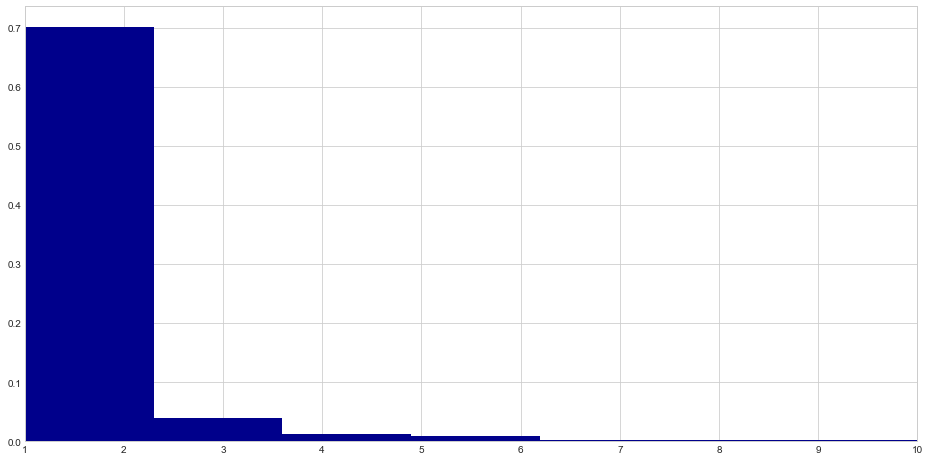

In [35]:
import matplotlib.pyplot  as plt
import matplotlib as mpl

mpl.style.use('seaborn-whitegrid')


ven_num = venues_df.groupby(['Postcode','Venue Category'], as_index=False).Venue.count()

fig, ax = plt.subplots(figsize=(16,8))
ax.hist(ven_num.Venue, color='darkblue', bins=10, density=True)
ax.set_xlim(1,10)
# ax.set_yscale('log')
plt.show()

---  
---

In [19]:
# Convert categorical feature to one-hot dataframe:
one_hot_df = pd.concat([venues_df.loc[:,'Postcode'],
                        pd.get_dummies(data=venues_df['Venue Category'])],
                       axis=1).groupby('Postcode', as_index=False).mean()
one_hot_df.head()

,Postcode,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,M1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,M1E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,M1G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,M1H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Lets define what number of clusters is optimal

In [20]:
from scipy.cluster.vq import kmeans, vq
import numpy as np

# Record distortions and minimum cluster size for each number of clusters:
distortions = []
med_cluster_size = []

for i in range(1,21):
    np.random.seed(1)
    centroids, distortion = kmeans(one_hot_df.iloc[:,1:].values, i)
    # Save minimum cluster size:
    med_cluster_size.append(pd.Series(vq(one_hot_df.iloc[:,1:].values, centroids)[0]).value_counts().median())
    # Save distortion:
    distortions.append(distortion)

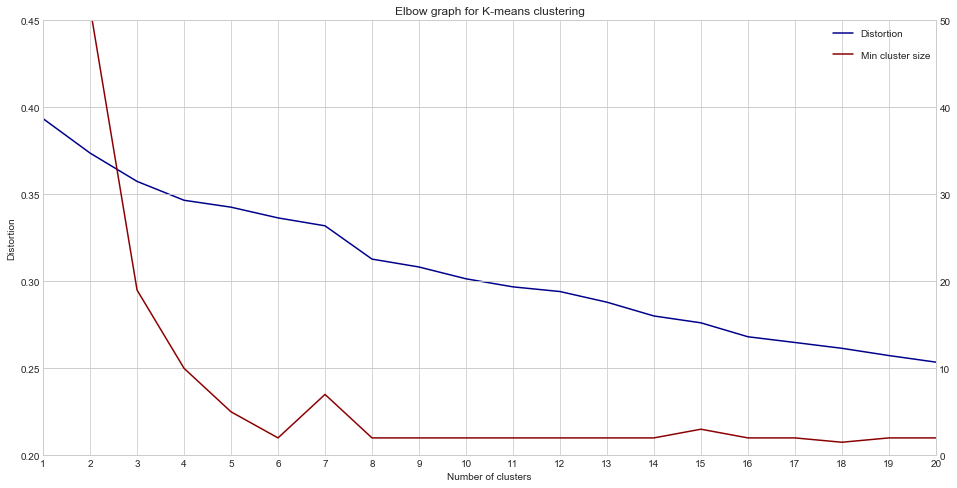

In [22]:
# Import libraries:
import matplotlib as mpl
import matplotlib.pyplot as plt

# Set style:
mpl.style.use('seaborn-whitegrid')

# Plot elbow graph to define optimum number of clusters:
fig, ax1 = plt.subplots(figsize=(16,8))
ax1.plot(range(1,21), distortions, color='darkblue', label='Distortion')
ax1.set_title('Elbow graph for K-means clustering')
ax1.set_ylabel('Distortion')
ax1.set_xlabel('Number of clusters')
ax1.set_xlim(1,20)
ax1.set_ylim(0.2,.45)
ax1.set_xticks(range(1,21))
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(range(2,21), med_cluster_size[1:], color='darkred', label='Min cluster size')
ax2.set_ylim(0,50)

ax1.legend(loc=(0.88,0.95))
ax2.legend(loc=(0.88,0.90))
plt.show()

##### We can see that 7 could be the optimal choise. So lets cluster neighborhoods into 7 groups:

In [23]:
np.random.seed(1)

# Copy data frame to save results:
neighbours_with_clusters = one_hot_df[['Postcode']].copy()

# Calculate centroids:
centroids, distortion = kmeans(one_hot_df.iloc[:,1:].values, 7)

# Cluster and save labels:
neighbours_with_clusters['Cluster'] = vq(one_hot_df.iloc[:,1:].values, centroids)[0]

# Show few rows:
neighbours_with_clusters.head()

,Postcode,Cluster
0,M1B,2
1,M1C,0
2,M1E,0
3,M1G,0
4,M1H,0


##### Append borough names and neighborhood names to cluster labels:

In [24]:
neighbours_with_clusters = pd.merge(left=result,
                                    right=neighbours_with_clusters,
                                    on='Postcode',
                                    how='left')

neighbours_with_clusters.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,2
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,0
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0


##### Plot Neighborhoods with cluster labels:

In [25]:
import numpy as np
import folium
from folium.plugins import ScrollZoomToggler, MeasureControl

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# Create color map:
colors_array = cm.gnuplot(np.linspace(0, 1, 7))
color_map = [colors.rgb2hex(i) for i in colors_array]

# Find Latitude and Longitude to center the map:
c_lat = np.mean([result.Latitude.max(), result.Latitude.min()])
c_lon = np.mean([result.Longitude.max(), result.Longitude.min()])

# Create Map:
toronto_ven_and_cl = folium.Map(location=[c_lat, c_lon], zoom_start=11)

# Add controls to the Map:
toronto_ven_and_cl.add_child(ScrollZoomToggler())
toronto_ven_and_cl.add_child(MeasureControl())

# Add Neighbours markers:
for pcode, borough, neigh, lat, lon, cluster in zip(*[neighbours_with_clusters[c] for c in neighbours_with_clusters.columns]):
    label = '{pcode}, {borough}, {neigh}, Cluster {cluster}'.format(pcode=pcode, borough=borough, neigh=neigh, cluster=cluster)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(location=[lat, lon],
                        popup=label,
                        color=color_map[cluster],
                        radius=7,
                        weight=1,
                        fill=True,
                        fill_color=color_map[cluster],
                        fill_opacity=0.5,
                        parse_html=False).add_to(toronto_ven_and_cl)
    
toronto_ven_and_cl

##### Find Top venues for each cluster

###### Append cluster labels to venues_df:

In [26]:
venues_with_clusters = pd.merge(left=venues_df,
                                    right=neighbours_with_clusters,
                                    on='Postcode',
                                    how='left')
venues_with_clusters.head()

,Postcode,Venue,Venue Category,Venue Latitude,Venue Longitude,Borough,Neighborhood,Latitude,Longitude,Cluster
0,M1B,Wendy's,Fast Food Restaurant,43.807448,-79.199056,Scarborough,"Rouge, Malvern",43.806686,-79.194353,2
1,M1B,Interprovincial Group,Print Shop,43.805630,-79.200378,Scarborough,"Rouge, Malvern",43.806686,-79.194353,2
2,M1C,Chris Effects Painting,Construction & Landscaping,43.784343,-79.163742,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,0
3,M1C,Royal Canadian Legion,Bar,43.782533,-79.163085,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,0
4,M1E,Swiss Chalet Rotisserie & Grill,Pizza Place,43.767697,-79.189914,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0


###### Find top venue categories for each cluster:

In [27]:
# Specify how many top categories we want to select:
num_top_venues = 10

# MCV - Most Common Venue
top_columns = ['MCV{}'.format(i+1) for i in range(num_top_venues)]

# Create blank Data Frame to store results:
top_N_df = neighbours_with_clusters.groupby('Cluster', as_index=False).Postcode.count().rename(columns={'Postcode':'Number of venues'})

# Iterate over venues_df and populate result data frame:
for cluster in top_N_df.Cluster.unique():
    
    # Get list of top venues for specific Postal code:
    top_venues = venues_with_clusters.loc[venues_with_clusters.Cluster == cluster, 'Venue Category'].value_counts().index
    
    # Extract Top N categories:
    N = min(num_top_venues, top_venues.size)
    for i in range(N):
        top_N_df.loc[top_N_df.Cluster == cluster, top_columns[i]] = top_venues[i]

# Fill NA with blank values:
top_N_df.fillna('', inplace=True)

# Order by cluster and show results:
top_N_df.sort_values(by='Number of venues', ascending=False, inplace=True)
top_N_df

,Cluster,Number of venues,MCV1,MCV2,MCV3,MCV4,MCV5,MCV6,MCV7,MCV8,MCV9,MCV10
0,0,69,Coffee Shop,Café,Restaurant,Italian Restaurant,Bakery,Bar,Hotel,Pizza Place,Japanese Restaurant,Sandwich Place
3,3,13,Park,Playground,Convenience Store,Bus Line,Trail,Pizza Place,Bakery,Construction & Landscaping,Women's Store,Bank
6,6,9,Pizza Place,Pharmacy,Coffee Shop,Fast Food Restaurant,Grocery Store,Sandwich Place,Bank,Convenience Store,Beer Store,Chinese Restaurant
2,2,7,Fast Food Restaurant,Bakery,Sandwich Place,Chinese Restaurant,Grocery Store,Supplement Shop,Burger Joint,Burrito Place,Convenience Store,Bus Line
4,4,2,Baseball Field,,,,,,,,,
5,5,2,Bank,Shopping Mall,Grocery Store,,,,,,,
1,1,1,Garden,Ice Cream Shop,,,,,,,,


### Conclusions

We can see, that Toronto central region is heavely populated by **Cluster 0** neighborhoods, what could be called "Food and drink".  
Around the Center there are also many neighborhoods from **Cluster 3**, that could be described as "Public places and services".  
**Clusters 6 and 2** provide some balance between Fastfood and Shoping.  
Other clusters are minor and describe 5 neighborhoods that have almost no venues in it.

### Thank you!

In [30]:
pd.read_html(url,header=0)[0]

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Not assigned
9,M8A,Not assigned,Not assigned
